<a href="https://colab.research.google.com/github/tensorflow-project/stable-diffusion/blob/main/textual_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git
!pip install -q tensorflow==2.11.0
!pip install pyyaml h5py

  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import random

import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt

### create an instance of the StableDiffusion() class
stable_diffusion = keras_cv.models.StableDiffusion()

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
def plot_images(images):
    """function to plot images in subplots
     Args: 
      - images: numpy arrays we want to visualize
    """
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
def assemble_image_dataset(urls):
    """Downloads a list of image URLs, resizes and normalizes the images, shuffles them, and adds random noise to create a 
    TensorFlow dataset object for them. 

    Args:
    - urls: A list of image URLs to download and use for the dataset.

    Returns:
    - image_dataset: A TensorFlow dataset object containing the preprocessed images.

    Notes:
    - This function assumes that all images have the same dimensions and color channels. 
    """
  
    # Fetch all remote files
    files = [tf.keras.utils.get_file(origin=url) for url in urls]

    # Resize images
    resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in files]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset

In [ ]:
MAX_PROMPT_LENGTH = 77

### our new concept which is later inserted in the different prompts (for training and image generation).
###The goal is to create an embedding for our placeholder_token
placeholder_token = "<my-broccoli-token>"


def pad_embedding(embedding):
    """Pads the input embedding with the end-of-text token to ensure that it has the same length as the maximum prompt length.

    Args:
    - embedding: A list of tokens representing the input embedding.

    Returns:
    - padded_embedding: A list of tokens representing the padded input embedding.
    """
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )

### Add our placeholder_token to our stable_diffusion Model
stable_diffusion.tokenizer.add_tokens(placeholder_token)


def assemble_text_dataset(prompts, placeholder_token):
    """Creates a text dataset consisting of prompt embeddings. 

    Args:
    - prompts: A list of string prompts to be encoded and turned into embeddings.

    Returns:
    - text_dataset: A text dataset containing the prompt embeddings.
    """
    ### inserts our placeholder_token into the different prompts
    prompts = [prompt.format(placeholder_token) for prompt in prompts]

    ### prompts are tokenized and encoded and then embeddings are padded
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]

    ### creates a dataset consisting of the different prompt embeddings and shuffles it
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    text_dataset = text_dataset.shuffle(100, reshuffle_each_iteration=True)
    return text_dataset

1356917/1356917 [==============================] - 0s 0us/step


In [ ]:
def assemble_dataset(urls, prompts, placeholder_token):
    """ Assembles a TensorFlow Dataset containing pairs of images and text prompts.

    Args:
    - urls: A list of URLs representing the image dataset
    - prompts: A list of text prompts corresponding to the images
    - placeholder_token: A string token representing the location where the prompt text will be inserted in the final text

    Returns:
    - A TensorFlow Dataset object containing pairs of images and their corresponding text prompts.
    """
    ### creating the image and test dataset
    image_dataset = assemble_image_dataset(urls)
    text_dataset = assemble_text_dataset(prompts)
    
    ### repeat both datasets to get several different combinations of images and text prompts
    # the image dataset is quite short, so we repeat it to match the length of the text prompt dataset
    image_dataset = image_dataset.repeat()

    # we use the text prompt dataset to determine the length of the dataset.  Due to
    # the fact that there are relatively few prompts we repeat the dataset 5 times.
    # we have found that this anecdotally improves results.
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

In [ ]:
### create a dataset consisting of happy broccoli stickers and happy prompts
happy_ds = assemble_dataset(
    urls = [
        "https://i.imgur.com/9zAwPyt.jpg",
        "https://i.imgur.com/qCNFRl4.jpg",
        "https://i.imgur.com/Q8qiVEN.jpg",
    ],
    prompts = [
        "a photo of a happy {}",
        "a photo of {}",
        "a photo of one {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of a cool {}",
        "a rendition of the {}",
        "a nice sticker of a {}",
        "a sticker of a {}",
        "a sticker of a happy {}",
        "a sticker of a lucky {}",
        "a sticker of a lovely {}",
        "a sticker of a {} in a positive mood",
        "a pixar chracter of a satisfied {}",
        "a disney character of a positive {}",
        "a sticker of a delighted {}",
        "a sticker of a joyful {}",
        "a sticker of a cheerful {}",
        "a drawing of a glad {}",
        "a sticker of a merry {}",
        "a sticker of a pleased {}",
    ],
    placeholder_token
)

8810/8810 [==============================] - 0s 0us/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
love_ds = assemble_dataset(
    urls = [
        "https://i.imgur.com/SqFxJfM.jpg",
        "https://i.imgur.com/hFqqp3p.jpg",
        "https://i.imgur.com/uGkSrzg.jpg",
    ],
    prompts = [
        "a photo of a {} in love",
        "a photo of {}",
        "a photo of one {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of an amorous {}",
        "a rendition of the {}",
        "a nice sticker of a {}",
        "a sticker of a {}",
        "a sticker of a {} in love",
        "a sticker of an amorous {}",
        "a sticker of a lovely {}",
        "a sticker of a {} in a positive mood",
        "a pixar chracter of a {} in love",
        "a disney character of a positive {}",
        "a sticker of a delighted {}",
        "a sticker of a joyful {}",
        "a drawing of a {} in love",
        "a drawing of a glad {}",
        "a sticker of a loving {}",
        "a sticker of a pleased {}",
    ],
    placeholder_token
)

7870/7870 [==============================] - 0s 0us/step


In [ ]:
sad_ds = assemble_dataset(
    urls = [
        "https://i.imgur.com/hlkuxBX.jpg",
        "https://i.imgur.com/kPH9XIh.jpg",
        "https://i.imgur.com/OR2oxyK.jpg",
    ],
    prompts = [
        "a photo of a sad {}",
        "a photo of {}",
        "a photo of one {}",
        "a photo of an unhappy {}",
        "a good photo of a {}",
        "a photo of the unhappy {}",
        "a photo of a depressed {}",
        "a rendition of the sad {}",
        "a nice sticker of a miserable {}",
        "a sticker of a {}",
        "a sticker of a downhearted {}",
        "a sticker of a sorrowful {}",
        "a sticker of an unhappy {}",
        "a sticker of a {} in a negative mood",
        "a pixar chracter of a depressed {}",
        "a disney character of a negative {}",
        "a sticker of a mourning {}",
        "a sticker of a grieving {}",
        "a drawing of a sad {}",
        "a drawing of a miserable {}",
        "a sticker of a sorrowful {}",
        "a sticker of a sobbing {}",
    ],
    placeholder_token
)

8773/8773 [==============================] - 0s 0us/step


In [ ]:
angry_ds = assemble_dataset(
    urls = [
        "https://i.imgur.com/mZswnIx.jpg",
        "https://i.imgur.com/qy1k0QK.jpg",
        "https://i.imgur.com/zUqbnBk.png",
    ],
    prompts = [
        "a photo of an angry {}",
        "a photo of {}",
        "a photo of one {}",
        "a photo of an annoyed {}",
        "a good photo of a {}",
        "a photo of the unhappy {}",
        "a photo of an enraged {}",
        "a rendition of the angry {}",
        "a nice sticker of a furious {}",
        "a sticker of a {}",
        "a sticker of an angry {}",
        "a sticker of a mad {}",
        "a sticker of an annoyed {}",
        "a sticker of a {} in a negative mood",
        "a pixar chracter of an enraged {}",
        "a disney character of a negative {}",
        "a sticker of a furious {}",
        "a sticker of an upset {}",
        "a drawing of an angry {}",
        "a drawing of a miserable {}",
        "a sticker of a miserable {}",
        "a sticker of an enraged {}",
    ],
    placeholder_token
)

29445/29445 [==============================] - 0s 0us/step


In [ ]:
### concatenate the different datasets with the different emotions
positive_ds = happy_ds.concatenate(love_ds)
negative_ds = sad_ds.concatenate(angry_ds)
train_ds = positive_ds.concatenate(negative_ds)
train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)

In [ ]:
### defining concept we want to build our new concept on
tokenized_initializer = stable_diffusion.tokenizer.encode("broccoli")[1]

### get the embedding of our basis concept to clone it to our new placeholder's embedding
new_weights = stable_diffusion.text_encoder.layers[2].token_embedding(tf.constant(tokenized_initializer))

# Get len of .vocab instead of tokenizer
new_vocab_size = len(stable_diffusion.tokenizer.vocab)

# The embedding layer is the 2nd layer in the text encoder
### get the weights of the concept we build on ('broccoli')
old_token_weights = stable_diffusion.text_encoder.layers[2].token_embedding.get_weights()
old_position_weights = stable_diffusion.text_encoder.layers[2].position_embedding.get_weights()

### unpack the old weights
old_token_weights = old_token_weights[0]

### old_token_weights has now the shape (vocab_size, embedding_dim)
### expand the dimension to be able to concatenate it with old_token_weights
new_weights = np.expand_dims(new_weights, axis=0)
new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

In [ ]:
# Have to set download_weights False so we can initialize the weigths ourselves
### create a new text encoder 
new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
    keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
    vocab_size=new_vocab_size,
    download_weights=False,
)
### we set the weights of the new_encoder to the same as in the old text_encoder except from the embedding layer
for index, layer in enumerate(stable_diffusion.text_encoder.layers):
    # Layer 2 is the embedding layer, so we omit it from our weight-copying
    if index == 2:
        continue
    new_encoder.layers[index].set_weights(layer.get_weights())

### set the weights of the embedding layer according to our new_weights
new_encoder.layers[2].token_embedding.set_weights([new_weights])

### set all weights of the other embeddings to the same values as in the initial text encoder
new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

### set the stable_diffusion text encoder to our new_encoder and compile it
### thus the stable_diffusion.text_encoder has the adjusted weights
stable_diffusion._text_encoder = new_encoder
stable_diffusion._text_encoder.compile(jit_compile=True)

In [ ]:
### we only train the encoder as we want to fine-tune the embeddings
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

stable_diffusion.text_encoder.layers[2].trainable = True

def traverse_layers(layer):
    """ Traverses the layers and embedding attributes of a layer

    Args:
    - layer: A text encoder layer

    Yields:
    -  layers and their corresponding embedding attributes
    """
    if hasattr(layer, "layers"):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, "token_embedding"):
        yield layer.token_embedding
    if hasattr(layer, "position_embedding"):
        yield layer.position_embedding

### iterates through the generator and adjusts the trainable attribute of the layers to trainable = True if it is part of the embedding
for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

### set the layer that only encodes the position of tokens in the prompts to trainable = False
new_encoder.layers[2].position_embedding.trainable = False

198180272/198180272 [==============================] - 2s 0us/step


In [ ]:
### put all the different components of stable diffusion model into a list
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder,
]

### check that only in the text encoder we have trainable weights
print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49409, 768])], [], []]


In [ ]:
# Remove the top layer from the encoder, which cuts off the variance and only returns the mean
### we make the encoder more efficient while still preserving the most important features
training_image_encoder = keras.Model(
    stable_diffusion.image_encoder.input,
    stable_diffusion.image_encoder.layers[-2].output,
)


def sample_from_encoder_outputs(outputs):
    """Returns a random sample from the embedding distribution given the mean and log variance tensors

    Args:
    - outputs: A tensor of shape (batch_size, embedding_dim*2), where the first embedding_dim values correspond to the mean of the distribution, 
               and the second embedding_dim values correspond to the log variance of the distribution

    Returns:
    - a tensor of shape (batch_size, embedding_dim), representing a random sample from the embedding distribution
    """
    mean, logvar = tf.split(outputs, 2, axis=-1)
    logvar = tf.clip_by_value(logvar, -30.0, 20.0)
    std = tf.exp(0.5 * logvar)
    sample = tf.random.normal(tf.shape(mean))
    return mean + std * sample


def get_timestep_embedding(timestep, dim=320, max_period=10000):
    """Returns the embedding of a specific timestep in the denoising process

    Args:
    - timestep (int): The timestep for which the embedding is requested
    - dim (int, optional): The dimensionality of the embedding, default is 320
    - max_period (int, optional): The maximum period, default is 10000

    Returns:
    - embedding (tf.Tensor): A tensor of shape (dim,) containing the embedding of the specified timestep
    """
    ### calculate half the dimensionality of the embedding
    half = dim // 2
    
    ### calculate frequencies using logarithmically decreasing values
    freqs = tf.math.exp(
        -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
    )
    
    ### compute arguments for cosine and sine functions
    args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
    
    ### concatenate cosine and sine values to create embedding
    embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
    
    ### return the embedding tensor
    return embedding

#### used for hidden state (output of text encoder)
def get_position_ids():
    """returns position IDs for the transformer model,
        the IDs range from 0 to MAX_PROMPT_LENGTH-1

    Returns:
    - position_ids (tf.Tensor): A tensor of shape (1, MAX_PROMPT_LENGTH) containing the position IDs
    """
    
    ### create a list of integers from 0 to MAX_PROMPT_LENGTH-1
    positions = list(range(MAX_PROMPT_LENGTH))
    
    ### convert the list to a tensor with dtype int32
    position_ids = tf.convert_to_tensor([positions], dtype=tf.int32)
    
    return position_ids


136824240/136824240 [==============================] - 1s 0us/step


In [ ]:
class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        ### needed to calculate the amount of noise at a specific time step
        self.noise_scheduler = noise_scheduler

    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            # Sample from the predicted distribution for the training image
            latents = sample_from_encoder_outputs(training_image_encoder(images))
            # The latents must be downsampled to match the scale of the latents used
            # in the training of StableDiffusion.  This number is truly just a "magic"
            # constant that they chose when training the model.
            latents = latents * 0.18215

            # Produce random noise in the same shape as the latent sample
            noise = tf.random.normal(tf.shape(latents))
            ### get the batch dimension
            batch_dim = tf.shape(latents)[0]

            # Pick a random timestep for each sample in the batch
            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )

            # Add noise to the latents based on the timestep for each sample
            ### using the scheduler to determine the amount of noise
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text in the training samples to use as hidden state in the diffusion model
            ### hidden state here means the output of the text encoder, thus the text embedding of our prompts
            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, get_position_ids()]
            )

            # Compute timestep embeddings for the randomly-selected timesteps for each sample in the batch
            ### ????
            timestep_embeddings = tf.map_fn(
                fn=get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )

            # Call the diffusion model
            ### calculate the noise predictions for each pixel(?)
            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )

            # Compute the mean-squared error loss and reduce it
            ### by taking the mean
            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        # Load the trainable weights and compute the gradients for them
        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        # Gradients are stored in indexed slices, so we have to find the index
        # of the slice(s) which contain the placeholder token.
        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        # Override the gradients, zeroing out the gradients for all slices that
        # aren't for the placeholder token, effectively freezing the weights for
        # all other tokens.
        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}

In [ ]:
### beta is the diffusion rate 
noise_scheduler = NoiseScheduler(
    ### beta_start determines the amount of noise added at the start of the denoising process
    beta_start=0.00085,
    ### beta_end at the end of the denoising process
    beta_end=0.012,
    ### the beta_schedule determines that the diffusion rate increases linearly
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

### Initialize the model we use to fine tune our concept
trainer = StableDiffusionFineTuner(stable_diffusion, noise_scheduler, name="trainer")
EPOCHS = 15
### learning rate decays depending on the number of epochs to avoid convergence issues in few epochs (?)
"""learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)"""
### inizialize the optimizer
optimizer = keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=1e-5, epsilon=1e-8, global_clipnorm=10
)

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

In [ ]:

### the actual training


trainer.fit(
    train_ds,
    epochs=1,
)


154/154 [==============================] - 356s 2s/step - loss: 0.0462


In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/weeeights.npy'


Mounted at /content/drive


In [ ]:
###get the weights of the text encoder and save the to google drive
text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights())

### Save the weights array to a file on your Google Drive
np.save(path, text_encoder_weights)

<ipython-input-23-3985f7e94cf5>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_encoder_weights = np.array(stable_diffusion.text_encoder.get_weights())


In [ ]:
###load the array of the weights of the text encoder from the last training from google drive
text_encoder_weights = np.load(path, allow_pickle=True)

### Set the weights of the text encoder
stable_diffusion.text_encoder.set_weights(text_encoder_weights)

50/50 [==============================] - 124s 2s/step


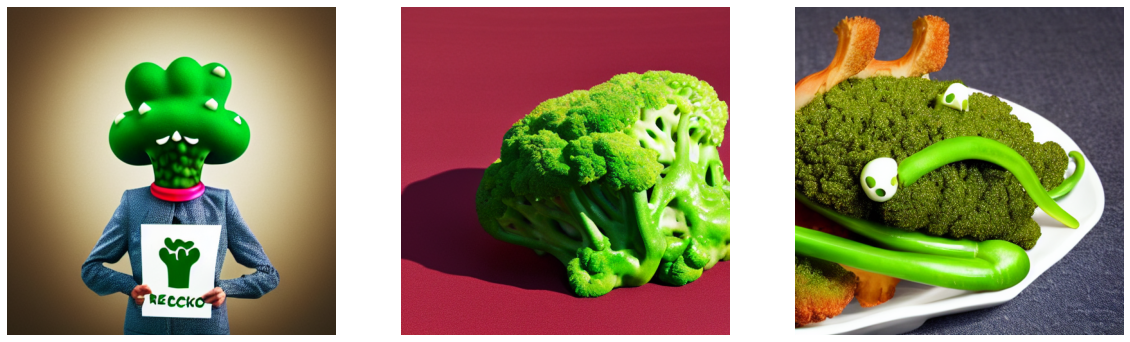

In [ ]:
### generate some examples and plot them according to our new concept and prompts
generated = stable_diffusion.text_to_image(
    f"a photo of a {placeholder_token} ",
    batch_size=3,
)
plot_images(generated)

50/50 [==============================] - 124s 2s/step


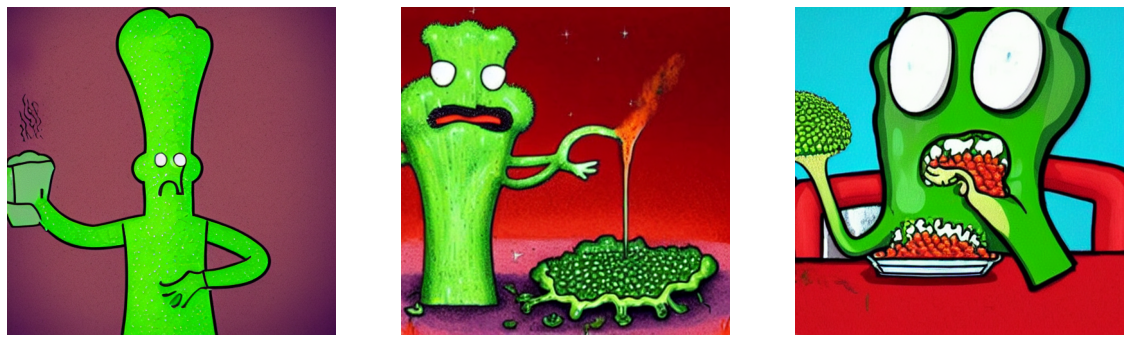

In [ ]:
generated = stable_diffusion.text_to_image(
    f"A masterpiece of a {placeholder_token} crying out to the heavens. "
    f"Behind the {placeholder_token}, an dark, evil shade looms over it - sucking the "
    "life right out of it.",
    batch_size=3,
)
plot_images(generated)

31/31 [==============================] - 59s 1s/step


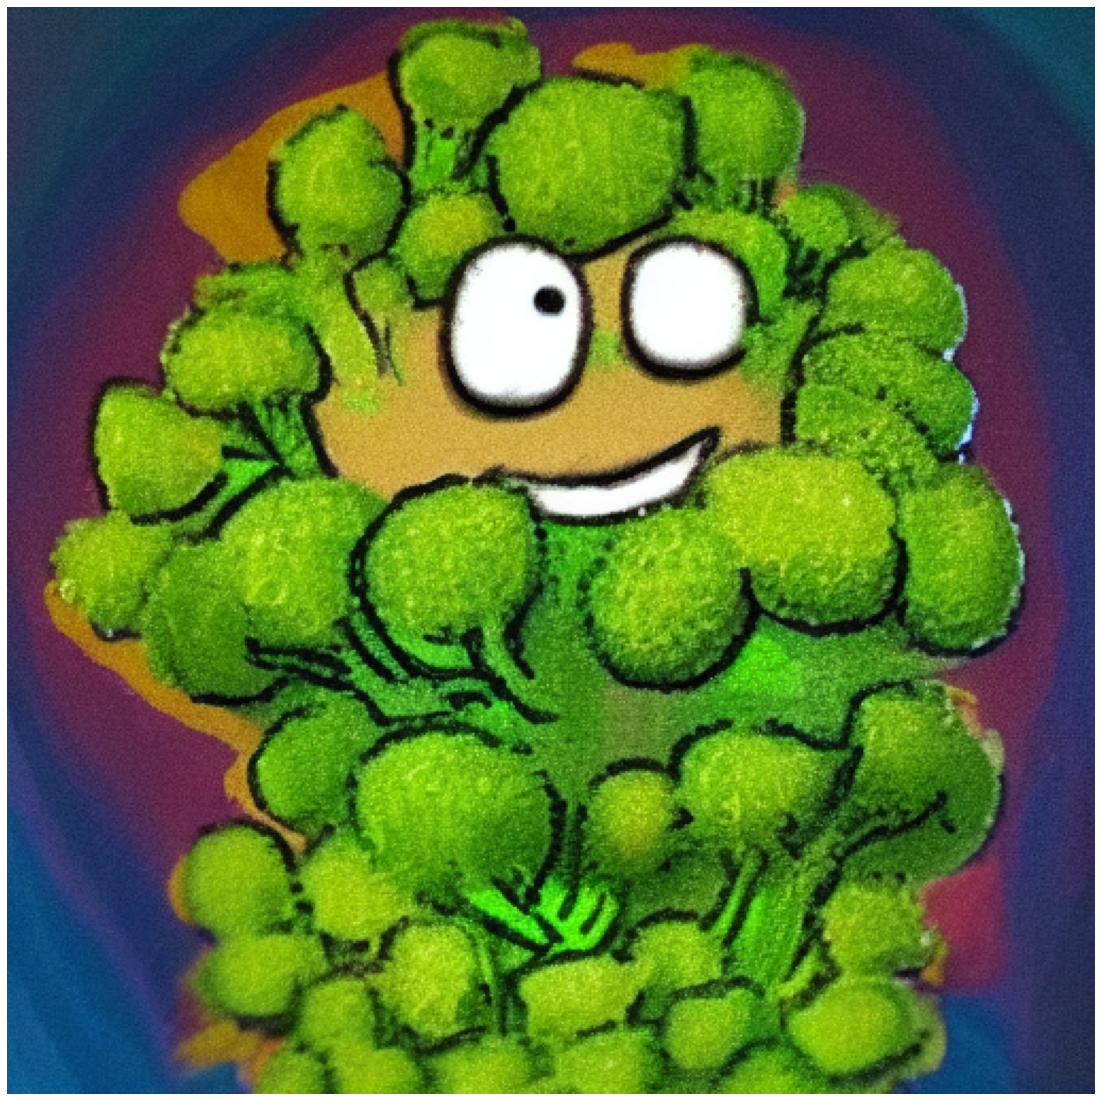

In [ ]:

generated = stable_diffusion.text_to_image(
    f" a happy {placeholder_token}.", batch_size=1,  num_steps=30, seed=2332
)
plot_images(generated)




In [ ]:
from PIL import Image
g = generated[0]
print("Shape of g:", g.shape)
print("Data type of g:", g.dtype)

pil_image = Image.fromarray(g, mode='RGB')

plt.imshow(pil_image)
plt.axis('off')
plt.show()
pil_image.save('example_image.jpg')

Shape of g: (512, 512, 3)
Data type of g: uint8


In [ ]:
import shutil
drive_folder = '/content/drive/MyDrive/bildeeer/'


for i in range(3):
    generated = stable_diffusion.text_to_image(
    f" a happy {placeholder_token}.", batch_size=1,  num_steps=25 )
    broc = generated[0]
    broc = Image.fromarray(broc, mode='RGB')

    broc.save(f'image_{i}.jpg')

    local_path = f'image_{i}.jpg'
    drive_path = os.path.join(drive_folder, f'image_{i}.jpg')  # Use f-string to include variable in file name
    shutil.copy(local_path, drive_path)

25/25 [==============================] - 29s 1s/step


In [ ]:
import shutil
drive_folder = '/content/drive/MyDrive/bildeeer/'

### get the number, we stopped the last time to name our pictures, to ensure each picture gets a different name
i_file = os.path.join(drive_folder, 'i.txt')
if os.path.isfile(i_file):
    with open(i_file, 'r') as f:
        i = int(f.read())
else:
    i = 0

for j in range(3):
    generated = stable_diffusion.text_to_image(
    f" a happy {placeholder_token}.", batch_size=1,  num_steps=25 )
    broc = generated[0]

    ### convert the array generated from our stable diffusion model into a picture
    broc = Image.fromarray(broc, mode='RGB')

    broc.save(f'image_{i}.jpg')

    ### save the picture to google drive
    local_path = f'image_{i}.jpg'
    drive_path = os.path.join(drive_folder, f'image_{i}.jpg')  # Use f-string to include variable in file name
    shutil.copy(local_path, drive_path)

    ### store the value of i in the file, to ensure no picture will have the same name
    i += 1
    with open(i_file, 'w') as f:
        f.write(str(i))

25/25 [==============================] - 30s 1s/step


25/25 [==============================] - 63s 3s/step


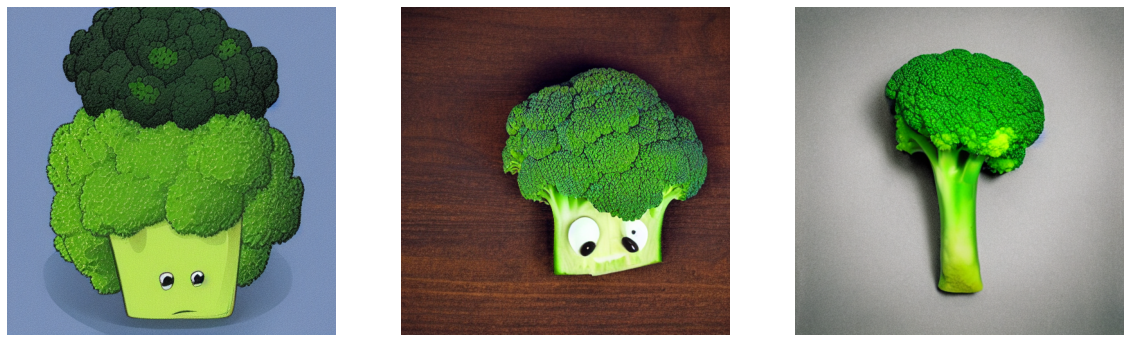

In [ ]:
generated = stable_diffusion.text_to_image(
    f" a sad {placeholder_token}.", batch_size=3, num_steps=25
)
plot_images(generated)


In [ ]:
generated = stable_diffusion.text_to_image(
    f" an angry {placeholder_token}.", batch_size=3, num_steps=25
)
plot_images(generated)


25/25 [==============================] - 62s 2s/step


In [ ]:
generated = stable_diffusion.text_to_image(
    f"a {placeholder_token} in love.", batch_size=3, num_steps=25
)
plot_images(generated)


25/25 [==============================] - 63s 3s/step


In [ ]:
generated = stable_diffusion.text_to_image(
    f"A mysterious {placeholder_token} approaches the great pyramids of egypt.",
    batch_size=3,
)
plot_images(generated)

15/50 [========>.....................] - ETA: 1:29

In [ ]:
generated = stable_diffusion.text_to_image(
    f"a hungry{placeholder_token}", seed=1337, batch_size=3
)
plot_images(generated)

50/50 [==============================] - 138s 3s/step
